In [254]:
import inspect
import json
import os
import time
import numpy as np
from functools import wraps
import pandas as pd
import seaborn as sns
import random
import tempfile
import pathlib

Platform class

In [276]:


class Platform:
    def __init__(self, algorithm, processing, table_path, compressed_path = None, decompressed_path = None, preprocessed_path = None, postprocessed_path = None, preprocess_inplace = True, postprocess_inplace = True):
        self.algorithm = algorithm
        self.processing = processing
        self.table_path = table_path
        self.compressed_path = compressed_path
        self.decompressed_path = decompressed_path
        self.preprocessed_path = preprocessed_path
        self.postprocessed_path = postprocessed_path
        self.preprocess_inplace = preprocess_inplace
        self.postprocess_inplace = postprocess_inplace
        self.logs = False


        self.benchmark = {"name" : type(self.algorithm).__name__, "table_path": table_path}

    def start(self, run_type="test", logs=False):
        self.logs = logs

        if self.logs:
            if isinstance(self.algorithm, LosslessCompressionAlgorithm):
                self.benchmark["isLossLess"] = True
            else:
                self.benchmark["isLossLess"] = False

            if isinstance(self.algorithm, LearningCompressionAlgorithm):
                self.benchmark["isLearning"] = True
            else:
                self.benchmark["isLearning"] = False

        with tempfile.TemporaryDirectory() as tmp:
            if self.compressed_path is None:
                self.compressed_path = pathlib.Path(tmp, 'compressed')
            if self.decompressed_path is None:
                self.decompressed_path = pathlib.Path(tmp, 'decompressed')
            if self.preprocessed_path is None and not self.preprocess_inplace:
                self.preprocessed_path = pathlib.Path(tmp, 'preprocessed')
            if self.postprocessed_path is None and not self.postprocess_inplace:
                self.postprocessed_path = pathlib.Path(tmp, 'postprocessed')
            if run_type == 'test':
                self.test()
            elif run_type == 'compress':
                self.preprocess_and_compress()
            elif run_type == 'decompress':
                self.decompress_and_postprocess()

    def measure_time(flag):
        def decorator(func):
            def wrapper(self, *args, **kwargs):
                start_time = time.time()
                result = func(self, *args, **kwargs)
                end_time = time.time()

                if getattr(self, flag):
                    print(f"Function {func.__name__} took {end_time - start_time} seconds to execute.")
                    self.benchmark[func.__name__ + "_time"] = end_time - start_time

                return result
            return wrapper
        return decorator

    @measure_time("logs")
    def preprocess_and_compress(self):
        with open(self.table_path, 'wb') as table_file, open(self.compressed_path, 'wb') as compressed_file, open(self.preprocessed_path, 'wb') as preprocessed_file:
            if self.preprocess_inplace:
                self.processing.do_preprocess(table_file, inplace=self.preprocess_inplace)
                self.algorithm.compress(table_file, compressed_file)
            else:
                self.processing.do_preprocess(table_file, preprocessed_file, inplace=self.preprocess_inplace)
                self.algorithm.compress(preprocessed_file, compressed_file)
            if self.logs:
                compression_rate = self.get_compression_rate(table_file, compressed_file)
                self.benchmark["compression_rate"] = compression_rate
        return 0

    @measure_time("logs")
    def decompress_and_postprocess(self):
        with open(self.compressed_path, 'wb') as compressed_file, open(self.decompressed_path, 'wb') as decompressed_file, open(self.postprocessed_path,'wb') as post_processed_file, open(self.table_path, 'rb') as profile_file:
            self.algorithm.decompress(compressed_file, decompressed_file)
            if self.postprocess_inplace:
                self.processing.do_postprocess(decompressed_file, inplace=self.postprocess_inplace)
            else:
                self.processing.do_postprocess(decompressed_file, post_processed_file, inplace=self.postprocess_inplace)

            if self.logs and profile_file is not None:
                loss_rate = self.get_loss_rate(profile_file, decompressed_file)
                self.benchmark["loss_rate"] = loss_rate

        return 0

    @measure_time("logs")
    def test(self):
        self.preprocess_and_compress()
        self.decompress_and_postprocess()
        return 0 #TODO: result codes

    def get_compression_rate(self, input_file, compressed_file): #I'm assuming compressed_table is actually bytes-like

        print(compressed_file.name)
        input_file.seek(0, os.SEEK_END)
        compressed_file.seek(0, os.SEEK_END)
        print(input_file.tell())
        print(compressed_file.tell())
        return input_file.tell() / compressed_file.tell()

    def get_loss_rate(self, input_file, decompressed_file):
        print("I am dummy: ", inspect.currentframe().f_code.co_name)
        return random.randint(0, 20)



IndentationError: expected an indented block after 'if' statement on line 49 (1712612185.py, line 50)

In [270]:
def json_platform(config_path):
    with open(config_path, 'r') as f:
        config = json.load(f)

    platform = Platform(globals()[config["Algorithm"]](), globals()[config["Processing"]](), config["table_path"])
    platform.start(config["run_type"], config["logs"])

json_platform("plug_config.json")

b''
I am dummy compression
C:\Users\Admin\AppData\Local\Temp\tmp654cho4z
168
168
Function preprocess_and_compress took 0.0009984970092773438 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.0007929801940918 seconds to execute.
Function test took 1.003786325454712 seconds to execute.


Compression Algorithm Classes

In [259]:
import abc

class CompressionAlgorithm(abc.ABC):
    def __init__(self):
        ...
    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def compress(self, input_file, compressed_file):
        ...

    @abc.abstractmethod
    def decompress(self, compressed_file, output_file):
        ...

class LearningCompressionAlgorithm(CompressionAlgorithm):

    @abc.abstractmethod
    def fit(self, training_data):
        ...

class NonLearningCompressionAlgorithm(CompressionAlgorithm):
    ...

class LosslessCompressionAlgorithm(CompressionAlgorithm):
    ...

class LossyCompressionAlgorithm(CompressionAlgorithm):
    ...

In [272]:
class DummyCompressionAlgorithm(LosslessCompressionAlgorithm, NonLearningCompressionAlgorithm):
    name = 'Dummy Compression Algorithm'
    def compress(self, input_file, compressed_file):
        input_file.seek(0)
        compressed_file.write(input_file.read())
        print(input_file.read())
        print("I am dummy compression")
        return 0 # TODO: status codes
    def decompress(self, compressed_file, output_file):
        compressed_file.seek(0)
        output_file.write(compressed_file.read())
        time.sleep(1)
        print("I am dummy decompression")
        return 0 # TODO: status codes

Processing Classes

In [273]:
class Processing(abc.ABC):
    def __init__(self):
        ...
    @property
    @abc.abstractmethod
    def name(self):
        ...

    @abc.abstractmethod
    def do_preprocess(self, raw_file, output_file, inplace):
        ...

    @abc.abstractmethod
    def do_postprocess(self, processed_file, output_file, inplace):
        ...

In [274]:
class DummyProcessing(Processing):
    name = "Dummy Pre/Post-Processing"
    def do_preprocess(self, raw_file, output_file=None, inplace=True):
        if inplace:
            return 0
        raw_file.seek(0)
        output_file.write(raw_file.read())
        return 0 # TODO: replace with enum / status codes
    def do_postprocess(self, processed_file, output_file=None, inplace=True):
        if output_file is None and not inplace: #raise exception?
            return 1
        if inplace:
            return 0
        output_file.write(processed_file.read())
        return 0 # TODO: replace with enum/status codes


Testing

In [275]:
benchmarks = []
Algos = [DummyCompressionAlgorithm(), DummyCompressionAlgorithm(), DummyCompressionAlgorithm()]
Processes = [DummyProcessing(), DummyProcessing()]
for algo in Algos:
    for proc in Processes:
        a = Platform(algo, proc, "flush.txt")
        a.start("test", logs=True)
        print(a.benchmark)
        benchmarks.append(a.benchmark)
        print("---------------------")

b''
I am dummy compression
C:\Users\Admin\AppData\Local\Temp\tmpj9n2mil5
19
19
Function preprocess_and_compress took 0.0009984970092773438 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.000805377960205 seconds to execute.
Function test took 1.0028076171875 seconds to execute.
{'name': 'DummyCompressionAlgorithm', 'table_path': 'flush.txt', 'isLossLess': True, 'isLearning': False, 'compression_rate': 1.0, 'preprocess_and_compress_time': 0.0009984970092773438, 'loss_rate': 6, 'decompress_and_postprocess_time': 1.000805377960205, 'test_time': 1.0028076171875}
---------------------
b''
I am dummy compression
C:\Users\Admin\AppData\Local\Temp\tmpltijcb8s
19
19
Function preprocess_and_compress took 0.0009946823120117188 seconds to execute.
I am dummy decompression
I am dummy:  get_loss_rate
Function decompress_and_postprocess took 1.0003223419189453 seconds to execute.
Function test took 1.001317024230957 seconds to execute.

In [264]:
#1. replace json with arguments of the class | DONE
#2. do not keep table in class instance | DONE
#3. change names of the Platform to more relevant | DONE
#4. rename compression to compress | DONE
#5. add ability to not compress tables every time Platform being created | I can just pass already preprocessed table to Platform
#and also pass the flush preprocessing class which do nothing

In [265]:
import matplotlib.pyplot as plt

def plot_graphics(n_values):
    plt.bar(range(len(n_values)), n_values)
    plt.title('Comparison of n Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()


In [266]:
def plot_benchmarks(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.barplot(x='index', y=column_name, data=df)

def plot_scatter(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.scatterplot(x='index', y=column_name, data=df)

def plot_hist(benchmarks, column_name):
    df = pd.DataFrame(benchmarks)
    df = df.reset_index()
    sns.histplot(x='index', y=column_name, data=df)



19
15
4
11
2
5


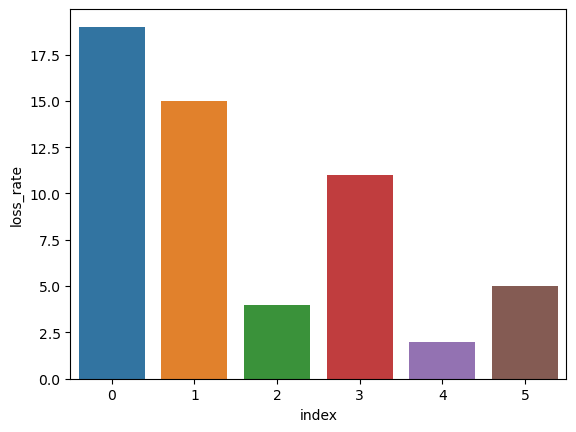

In [267]:
plot_benchmarks(benchmarks, "loss_rate")
for i in benchmarks:
    print(i["loss_rate"])

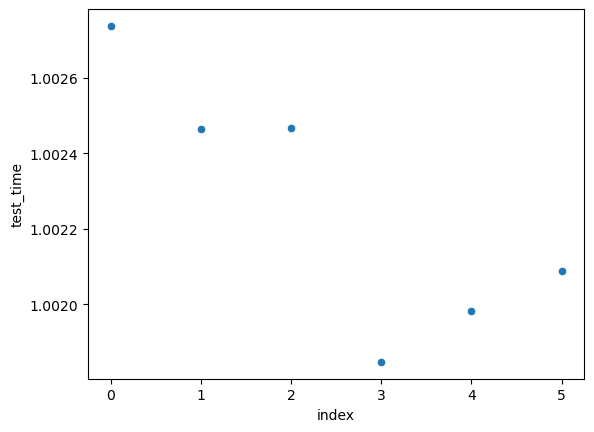

In [268]:
plot_scatter(benchmarks, "test_time")

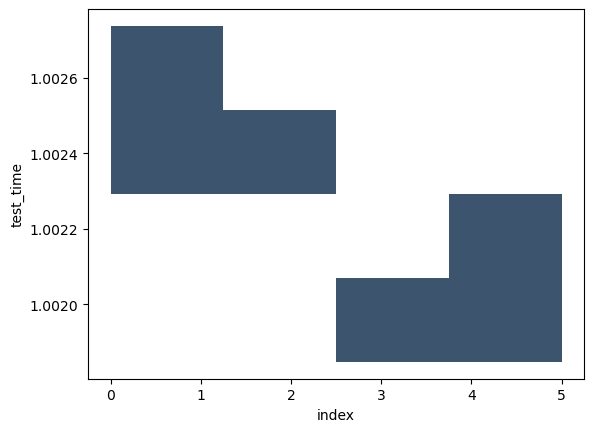

In [269]:
plot_hist(benchmarks, "test_time")